# survival analysis

A set of statistical approaches used to investigate the "time to event","churn prediction"
- censored data (special missing data type), so can't apply the regression directly
- survival function: $ S(t) = Pr(T > t) $
- hazard finction: $ \lambda(t) =\lim_{\delta t\to0}{\frac{Pr(t\leq T\leq t+\delta t\mid T>t)}{\delta t}}= -\frac{S^\prime(t)}{S(t)}=\frac{f(t)}{S(t)} $

2.134783454153106 0 0.9980276199467129


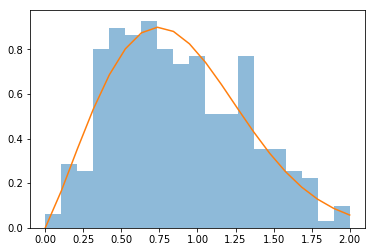

In [2]:
# Weibull disribution
%matplotlib inline
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sample=stats.weibull_min.rvs(c=2,scale=1,size=300,loc=0) # c:shape parameter, scale: scale parameter
#print(sample)

#stats.exponweib.fit(sample,floc=0,f0=1)
shape,loc,scale=stats.weibull_min.fit(sample,floc=0)
print(shape,loc,scale)
plt.hist(sample,bins=np.linspace(0,int(max(sample)),20),density=True,alpha=0.5)
x=np.linspace(0,int(max(sample)),20)
y=[(shape / scale) * (u / scale)**(shape-1) * np.exp(-(u/scale)**shape) for u in x]

plt.plot(x,y,label='weibull')
plt.show()

# Kaplan-Meier estimate
- a non-parametric statistic used to estimate the survival function from lifetime data
- 
$ S(t)=\prod_{i:t_i\leq t}(1-\frac{d_i}{n_i}) $

   ID Retail date Production date  Group
0   1  2014-12-09      2014-10-23      1
1   2  2014-12-09      2014-10-17      1
2   3  2014-12-14      2014-10-14      1
       ID  Mileage Repair date  Censored
0  1689.0    82441  2017-08-31         0
1  2736.0    66951  2017-08-30         0
2  1515.0    75500  2017-07-24         0
   ID Retail date Production date  Group  Mileage Repair date  Censored  \
0   1  2014-12-09      2014-10-23      1      NaN  2018-12-19       1.0   
1   2  2014-12-09      2014-10-17      1      NaN  2018-12-19       1.0   
2   3  2014-12-14      2014-10-14      1  69879.0  2018-05-28       0.0   
3   4  2014-12-15      2014-11-11      1  31563.0  2018-08-22       0.0   
4   5  2014-12-16      2014-10-20      1      NaN  2018-12-19       1.0   

   Operating_days  Operating_time  
0            1471              48  
1            1471              48  
2            1261              41  
3            1346              44  
4            1464              48  
    t

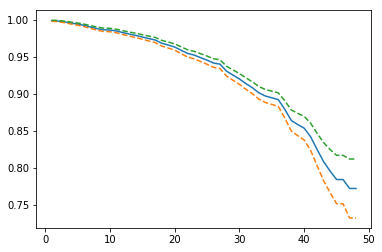

In [6]:
#  Kaplan-Meier Estimate, create the life table

production=pd.read_excel("./data/production.xlsx",
                         parse_dates=['Retail date','Production date'],
                         date_parser=lambda x: pd.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S"))
failure=pd.read_excel("./data/failure.xlsx",
                     parse_dates=['Repair date'],
                     date_parser=lambda x:pd.datetime.strptime(str(x),"%Y-%m-%d %H:%M:%S"))
failure['Censored']=0
print(production.head(3))
print(failure.head(3))
sample_list=production.merge(failure,on='ID',how='left')
sample_list['Repair date'].fillna(value=np.max(sample_list['Repair date']),inplace=True)
sample_list['Censored'].fillna(value=1,inplace=True)
sample_list['Operating_days']=list(map(lambda x: x.days,sample_list['Repair date']-sample_list['Retail date']))
sample_list['Operating_time']=sample_list['Operating_days']//30.5
print(sample_list.head(5))

life_table=sample_list.loc[:,['Operating_time','Censored']].groupby(['Operating_time']).agg({"Censored":["size","sum"]}).reset_index()
life_table.columns = ['_'.join(col) for col in life_table.columns.values]

life_table['n_event']=life_table['Censored_size']-life_table['Censored_sum']
life_table=life_table.loc[life_table['Operating_time_']>0,:]
life_table.sort_values(by=['Operating_time_'],ascending=False,inplace=True)
life_table['n_risk']=life_table['Censored_size'].cumsum()
life_table.sort_values(by=['Operating_time_'],ascending=True,inplace=True)
life_table.rename(columns={'Operating_time_':'time','Censored_sum':'n_censored'},inplace=True)
life_table.drop(columns=['Censored_size'],inplace=True)

life_table['hazard_rate']=life_table['n_event']/life_table['n_risk']
life_table['survival_rate']=1-life_table['hazard_rate']
life_table['survival']=life_table['survival_rate'].cumprod()
life_table['failure_probability']=1-life_table['survival']

# standard deviation according to Greenwood formula
d_i=life_table['n_event']
n_i=life_table['n_risk']
life_table['std_error']=life_table['survival']*np.sqrt(np.cumsum(d_i/(n_i*(n_i-d_i))))
life_table['lower_95_ci']=life_table['survival']-stats.norm.ppf(1-.05/2)*life_table['std_error']
life_table['upper_95_ci']=life_table['survival']+stats.norm.ppf(1-.05/2)*life_table['std_error']
print(life_table.head(5))
plt.plot(life_table['time'],life_table['survival'])
plt.plot(life_table['time'],life_table['lower_95_ci'], linestyle='dashed')
plt.plot(life_table['time'],life_table['upper_95_ci'], linestyle='dashed')
plt.show()

# weibull regression
- Parametric regression model for survival data
- univariate regression

Weibull model train finished with score: 97.11571195761121%
Weight: 1.551033921803207, Bias: -7.779230574903931


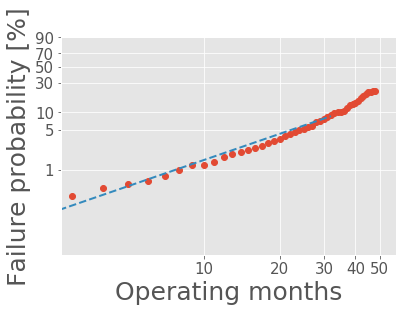

In [138]:
from sklearn import linear_model
import logging

class Input_builder(object):
    def __init__(self):
        pass

    def __call__(self, model,x,y=None,train_window=20,train_window_2=None):
        if model=='weibull':
            return self.create_weibull_input(x,y,train_window)
        elif model=='svm' or model=='lstm':
            return self.create_RNN_input(x,train_window=20)
        elif model=='seq2seq':
            return self.create_seq2seq_basic_input(x,train_window,train_window_2)
        elif str(model)=='arima':
            return x.iloc[:,-1].values
        elif str(model)=='xgb':
            return self.create_xgb_input(x)

    def create_weibull_input(self,x,y,train_windows=20):
        index_end=len(y)-1
        y=list(y)
        for yy in y[::-1]:
            if yy!=y[-1]:
                index_end=y.index(yy)
                break
        index_begin=index_end-train_windows if (index_end-train_windows>0) else 1
        x,y=x[index_begin:index_end],y[index_begin:index_end]
        logging.info("Weibull train data {}".format(len(x)))
        return np.array(x),np.array(y)
        
        
alpha=10e-7
class Weibull_model(object):
    def __init__(self):
        pass

    def train(self,x,y,train_window):
        self.x = x
        self.y = y
        train_x, train_y = Input_builder().create_weibull_input(x, y, train_windows=train_window)
        self.x_weibull = np.log(train_x)
        self.y_weibull = np.log(-np.log(1 - train_y) + alpha)
        self.x_weibull=self.x_weibull.reshape(-1,1)
        self.model=linear_model.LinearRegression()
        self.model.fit(self.x_weibull,self.y_weibull)
        print("Weibull model train finished with score: {}%".format(100*self.model.score(self.x_weibull,self.y_weibull)))
        self.weight_weibull=self.model.coef_[0]
        self.bias_weibull=self.model.intercept_
        print("Weight: %s, Bias: %s" % (self.weight_weibull,self.bias_weibull))
        return self.weight_weibull,self.bias_weibull

    def predict_by_interval(self,predicted_interval,return_full=True):
        x_max=max(self.x)
        #assert x_max< (len(self.x)+5)
        x_future=[i for i in np.arange(x_max+1,x_max+predicted_interval+1)]
        x_future_weibull=np.log(x_future).reshape(-1,1)
        y_predict_weibull=self.weight_weibull*x_future_weibull+self.bias_weibull
        y_predict=1.0-1.0/(np.exp(np.exp(y_predict_weibull-alpha)))
        y_predict=y_predict.reshape(y_predict.shape[0],)

        if return_full:
            self.x_future = list(self.x) + list(x_future)
            self.y_future = list(self.y) + list(y_predict)
            return self.x_future, self.y_future
        else:
            return list(x_future),list(y_predict)


    def predict_by_calendar(self,interval_samples,calendar_failures,predicted_interval,output_file,return_full=True,include_future_samples=False):
        """
        interval_samples: [sample0,sample1,sample2] cumulative value for each operating time
        calendar_failures: {Date1: failure1,Date2: failure2}
        """
        x_future,y_future=self.predict_by_interval(predicted_interval+1)
        failure_rate_interval =[y_future[i+1]-y_future[i] for i in range(len(y_future)-1)]
        failure_rate_interval=[max(alpha,x) for x in failure_rate_interval]
        logging.info("Use {} data to further predict {} future".format(len(interval_samples),predicted_interval))
        assert len(interval_samples)+predicted_interval==len(failure_rate_interval)

        if return_full:
            pass
        else:
            calendar_failures=pd.DataFrame()

        if include_future_samples:
            #Todo : check if it's better or not
            samples_future=interval_samples+[np.mean(interval_samples)]*predicted_interval

        else:
            for i in range(1,predicted_interval+1):
                samples_failure_rate_interval=failure_rate_interval[i:i+len(interval_samples)]
                failure_interval=sum(interval_samples*samples_failure_rate_interval)
                calendar_failures=calendar_failures.append({"Failures":failure_interval},ignore_index=True)
        calendar_failures.to_csv(output_file,index=False)
        return calendar_failures

    def plot(self):
        plt.style.use('ggplot')
        fig,ax=plt.subplots()
        x, y = np.array(self.x), np.array(self.y)
        x_weibull,y_weibull=np.log(x),np.log(-np.log(1 - y) + alpha)
        ax.plot(x_weibull,y_weibull,marker='o',linestyle='')
        x_plot = np.arange(np.log(1), np.log(len(x)), np.log(2))
        ax.plot(x_plot,self.weight_weibull*x_plot+self.bias_weibull,'--',linewidth=2)

        ax.set_yticks(list(map(lambda y: np.log(-np.log(1 - y) + alpha),np.array([0.01,0.05]+[i/100 for i in range(10,100,20)]))))
        ax.set_yticklabels(np.array([1, 5] + [i for i in range(10, 100, 20)]), fontsize=15)
        ax.set_xticks(list(map(lambda x: np.log(x),[i*10 for i in range(1, 10)])))
        ax.set_xticklabels([i*10 for i in range(1, 10)])
        ax.set_xlim([1, np.log(len(self.x)+10)])
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.set_xlabel('Operating months', fontsize=25)
        ax.set_ylabel('Failure probability [%]', fontsize=25)
        plt.show()

        
x,y=life_table['time'].values,life_table['failure_probability'].values
weibull_model = Weibull_model()
weibull_model.train(x,y,train_window=50)
x_full_pred,y_full_pred=weibull_model.predict_by_interval(predicted_interval=len(x),return_full=False)
weibull_model.plot()


# log-rank test
- To compare the survival times of two or more groups
- univariate analysis for categorical groups

# cox proportional hazards regression
- To describe the effect of categorical or quantitative variables on survival
- assume that the effects of the predictor variables upon survival are constant over time and are additive in one scale, the hazard for any individual is a fixed proportion of the hazard for any other individual
- A semi-parametric model, multivariate regression
- $ h(t|x)=h_0(t) \times exp(b_1x_1+b_2x_2+ \ldots +b_px_p) $ 
- Cumulative hazard at a time t is the risk of dying between time 0 and time t, and the survivor function at time t is the probability of surviving to time t
- cox regression aims to estimate the hazard ratio, while logistic regression aims to estimate the odds ratio
- [reference](http://courses.washington.edu/b515/l17.pdf)

# tree based survival model

# mixed weibull

# Bayesian restoration maximization
- [Bayesian estimation of Weibull mixture in heavily censored data setting](https://hal.archives-ouvertes.fr/hal-01645618/document)